In [2]:
from torchaudio.transforms import AmplitudeToDB
import os

import torch

from config import SynthConfig, Config
from dataset.ai_synth_dataset import AiSynthDataset, create_data_loader
from model import helper
from model.model import SimpleSynthNetwork
from run_scripts.inference.inference_helper import inference_loop, process_batch_inference
from synth.synth_architecture import SynthModular
import matplotlib.pyplot as plt

from librosa import amplitude_to_db

In [3]:
device = 'cuda:0'
preset = 'BASIC_FLOW'

## Create dataset
dataset_to_visualize = 'basic_flow_new_toy'
split_to_visualize = 'test'
batch_size = 10
data_dir = os.path.join('data', dataset_to_visualize, split_to_visualize, '')

wav_files_dir = os.path.join(data_dir, 'wav_files', '')
params_csv_path = os.path.join(data_dir, 'params_dataset.pkl')

ai_synth_dataset = AiSynthDataset(params_csv_path, wav_files_dir, device)
test_dataloader = create_data_loader(ai_synth_dataset, batch_size, 0, shuffle=False)


## init
synth_cfg = SynthConfig()
cfg = Config()

synth_obj = SynthModular(synth_cfg=synth_cfg,
                         sample_rate=cfg.sample_rate,
                         signal_duration_sec=cfg.signal_duration_sec,
                         device=device,
                         preset=preset)

transform = helper.mel_spectrogram_transform(cfg.sample_rate).to(device)
normalizer = helper.Normalizer(cfg.signal_duration_sec, synth_cfg)

## Load model
model_ckpt_path1 = r'experiments/current/basic_flow_test/ckpts/synth_net_epoch10.pt' # param only
model_ckpt_path2 = r'experiments/current/basic_flow_w_spec_loss_low_weight/ckpts/synth_net_epoch30.pt' # param + spec
model1 = SimpleSynthNetwork(preset, synth_cfg, cfg, device, backbone='resnet').to(device)
model2 = SimpleSynthNetwork(preset, synth_cfg, cfg, device, backbone='resnet').to(device)

In [4]:
audio_batch = test_dataloader.__iter__().next()

In [ ]:
model1.load_state_dict(torch.load(model_ckpt_path1, map_location=device)['model_state_dict'])
model1.eval()
model2.load_state_dict(torch.load(model_ckpt_path2, map_location=device)['model_state_dict'])
model2.eval()

In [6]:
results1, metrics1 = process_batch_inference(audio_batch, transform, model1, normalizer.denormalize, synth_obj, device, cfg)

C:\Users\Noy Uzrad\PycharmProjects\ai_synth\src\run_scripts\inference\inference_helper.py:221: FutureWarning: Pass y=[0.00112411 0.0011152  0.00110542 ... 0.00145583 0.001449   0.00144165] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc1 = mfcc(sound1, sr=sample_rate, n_mfcc=40)
C:\Users\Noy Uzrad\PycharmProjects\ai_synth\src\run_scripts\inference\inference_helper.py:222: FutureWarning: Pass y=[0.00125569 0.0012533  0.00124783 ... 0.00034684 0.00034066 0.00033472] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc2 = mfcc(sound2, sr=sample_rate, n_mfcc=40)
C:\Users\Noy Uzrad\PycharmProjects\ai_synth\src\run_scripts\inference\inference_helper.py:221: FutureWarning: Pass y=[ 0.00021173  0.00034984  0.00049423 ... -0.00136622 -0.00135921
 -0.00131699] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc1 = mfcc(sound1, sr=sample_ra

In [7]:
results2, metrics2 = process_batch_inference(audio_batch, transform, model2, normalizer.denormalize, synth_obj, device, cfg)

C:\Users\Noy Uzrad\PycharmProjects\ai_synth\src\run_scripts\inference\inference_helper.py:222: FutureWarning: Pass y=[-0.0004677  -0.0004693  -0.00047032 ... -0.00068673 -0.00069697
 -0.00070597] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc2 = mfcc(sound2, sr=sample_rate, n_mfcc=40)
C:\Users\Noy Uzrad\PycharmProjects\ai_synth\src\run_scripts\inference\inference_helper.py:222: FutureWarning: Pass y=[ 0.00204302  0.00230491  0.00256111 ... -0.00038032 -0.00054484
 -0.00065546] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc2 = mfcc(sound2, sr=sample_rate, n_mfcc=40)
C:\Users\Noy Uzrad\PycharmProjects\ai_synth\src\run_scripts\inference\inference_helper.py:222: FutureWarning: Pass y=[ 3.185172e-05  6.441264e-04  8.525368e-04 ... -8.057392e-04 -9.239860e-04
 -8.014069e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc2 =

In [8]:
for metrics in [metrics1, metrics2]:
    for k, v in metrics.items():
        metrics2[k] = v / 10

In [9]:
metrics1

defaultdict(float,
            {'lsd_value': 616.885009765625,
             'pearson_stft': 6.873675721354875,
             'pearson_fft': 4.81489135158127,
             'mean_average_error': 4.900597095489502,
             'mfcc_mae': 59.76694107055664,
             'spectral_convergence_value': 7.485891342163086})

In [10]:
def plot_result(target_audio, pred_audio1, pred_audio2, target_spec, pred_spec1, pred_spec2):

    fig, ax = plt.subplots(2, 3, figsize=(20, 10))

    ax[0, 0].plot(target_audio)
    ax[0, 1].plot(pred_audio1)
    ax[0, 2].plot(pred_audio2)

    ax[1, 0].imshow(amplitude_to_db(target_spec), origin='lower', aspect='auto', cmap=plt.get_cmap('inferno'))
    ax[1, 1].imshow(amplitude_to_db(pred_spec1), origin='lower', aspect='auto', cmap=plt.get_cmap('inferno'))
    ax[1, 2].imshow(amplitude_to_db(pred_spec2), origin='lower', aspect='auto', cmap=plt.get_cmap('inferno'))

    plt.show()


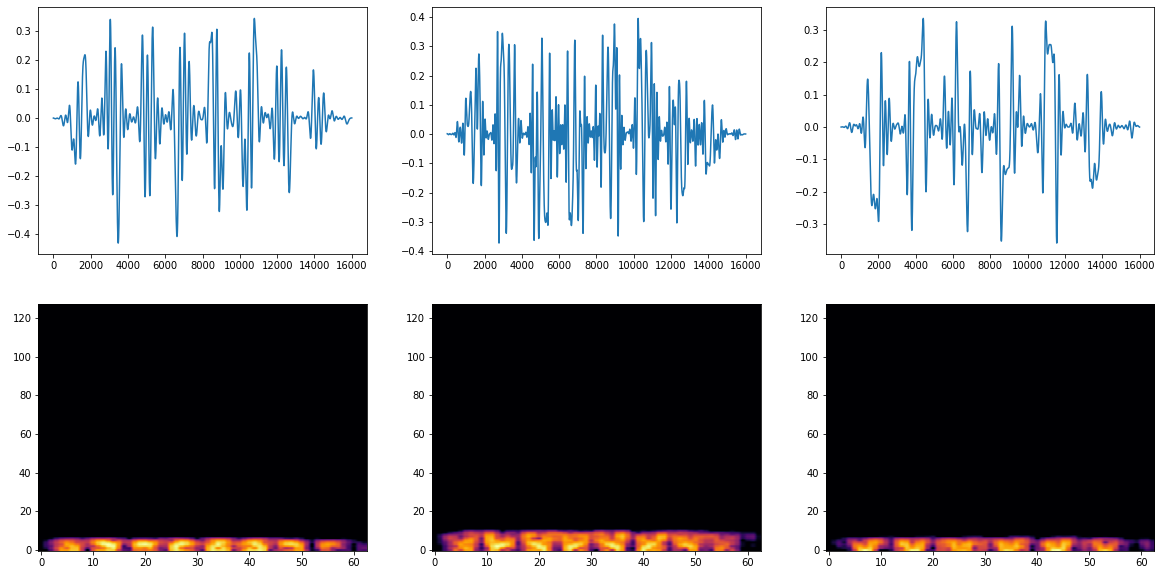

Sound 0 target

Sound 0 model1 prediction

Sound 0 model2 prediction

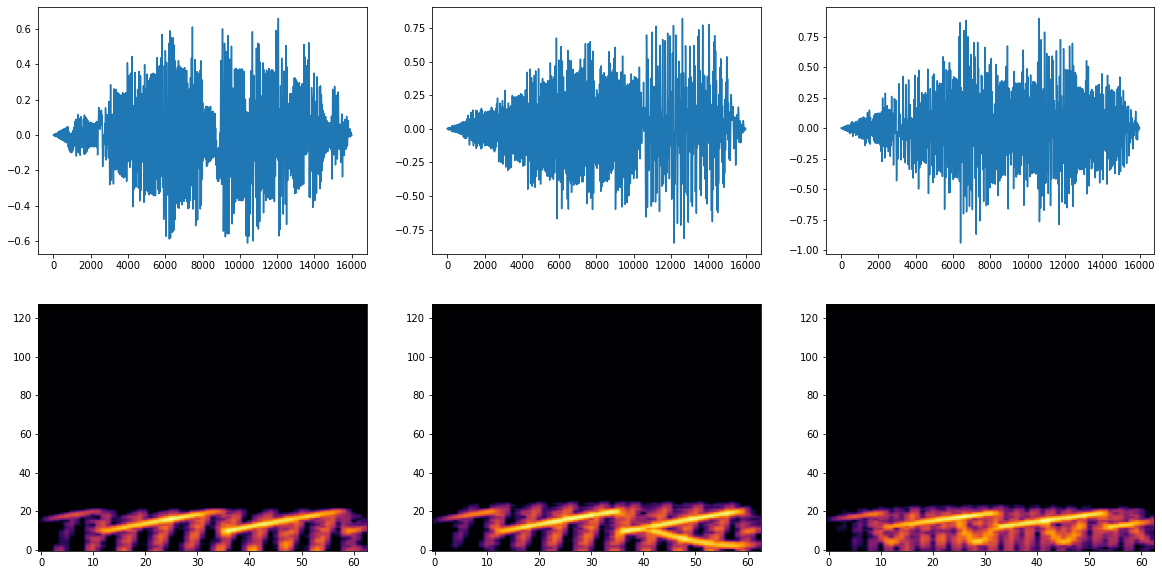

Sound 1 target

Sound 1 model1 prediction

Sound 1 model2 prediction

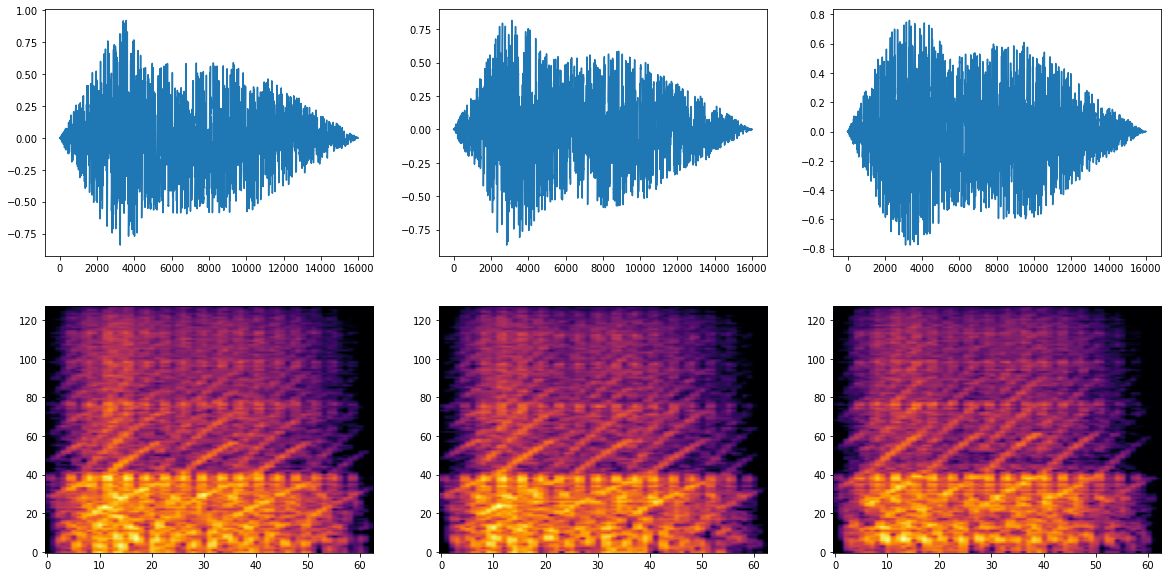

Sound 2 target

Sound 2 model1 prediction

Sound 2 model2 prediction

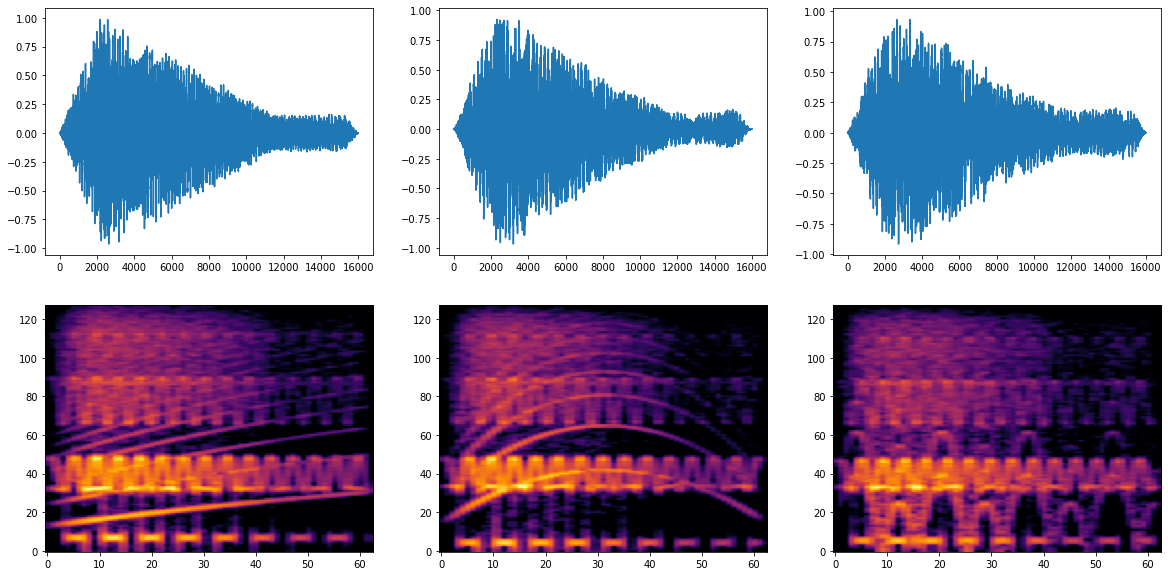

Sound 3 target

Sound 3 model1 prediction

Sound 3 model2 prediction

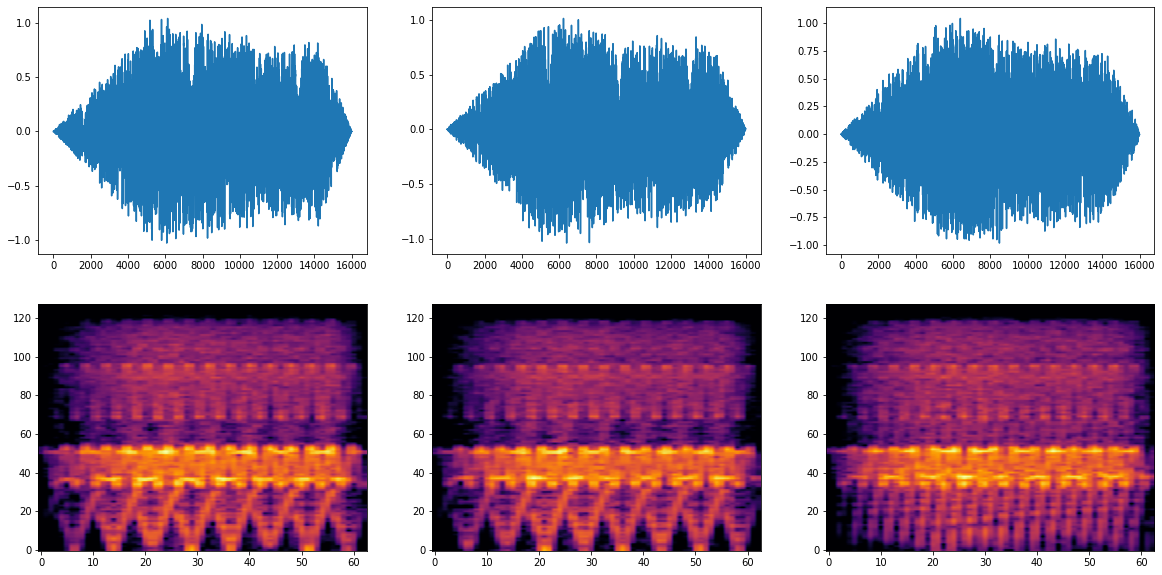

Sound 4 target

Sound 4 model1 prediction

Sound 4 model2 prediction

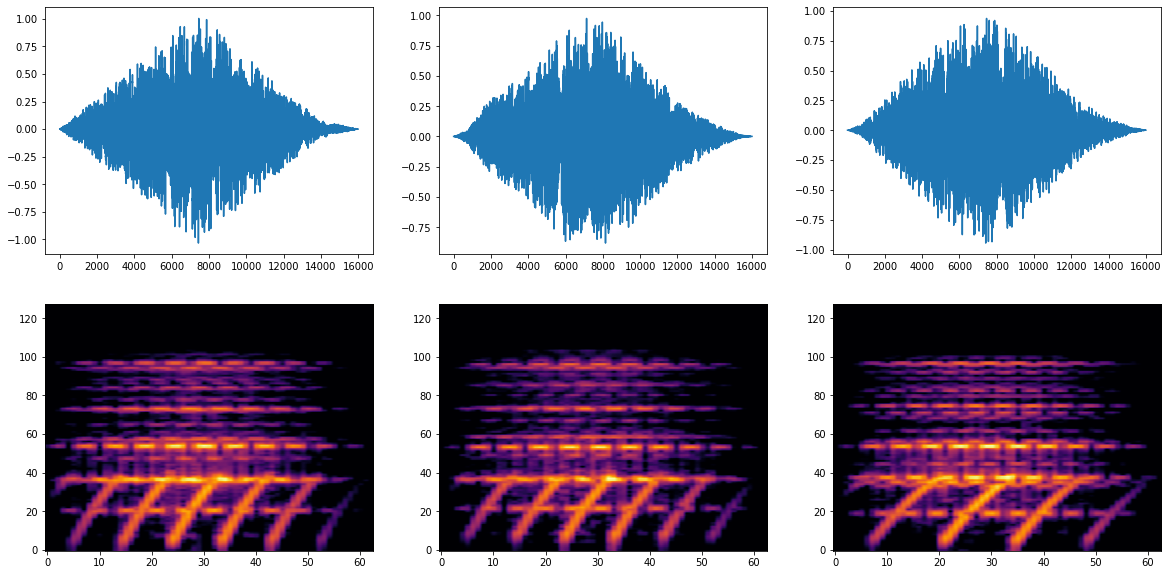

Sound 5 target

Sound 5 model1 prediction

Sound 5 model2 prediction

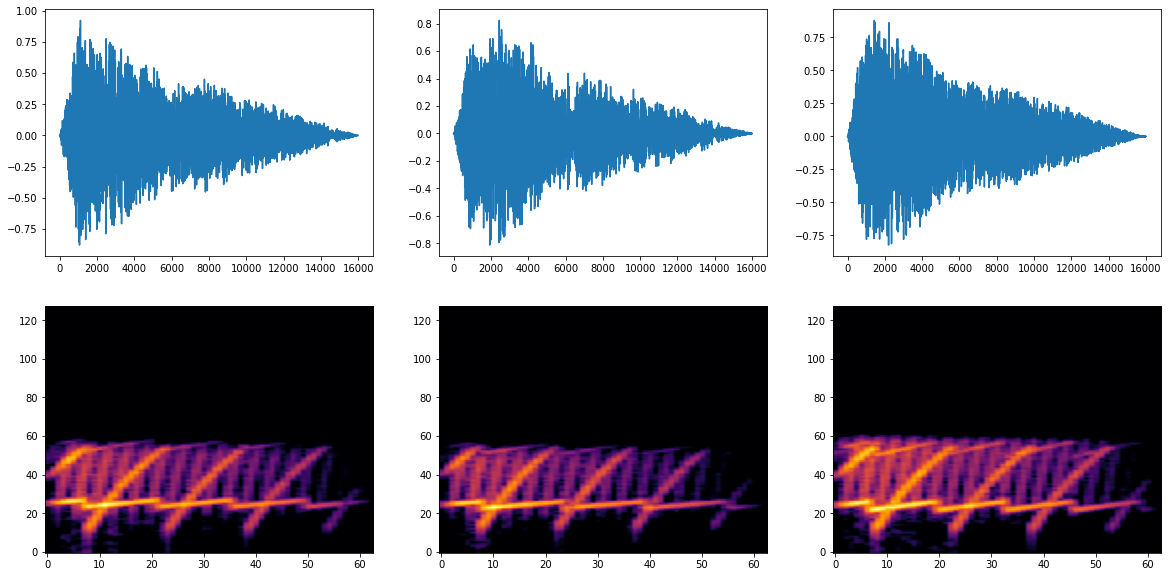

Sound 6 target

Sound 6 model1 prediction

Sound 6 model2 prediction

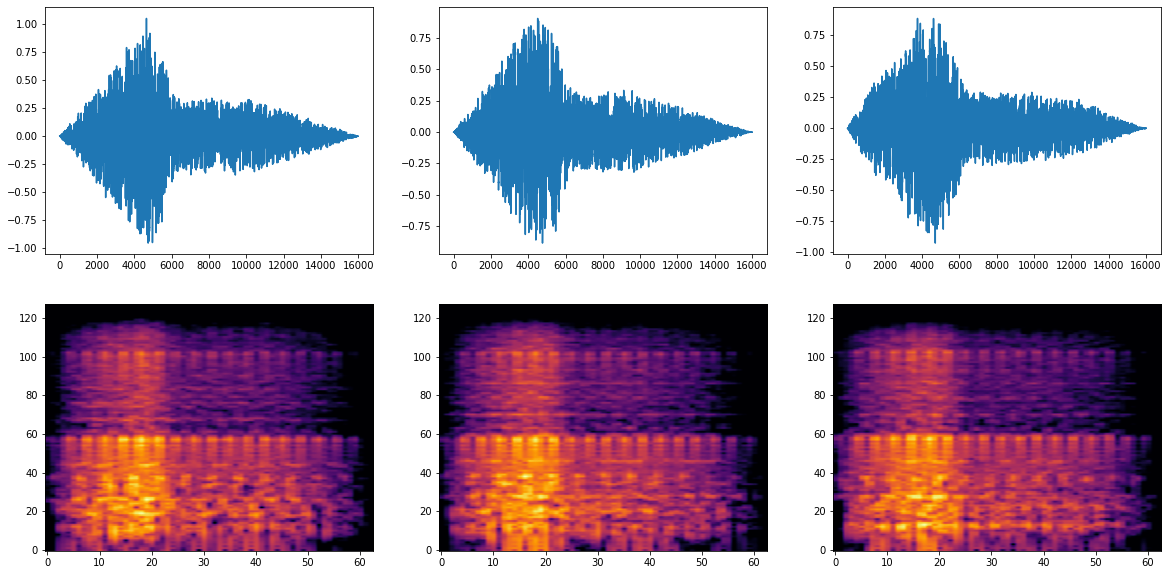

Sound 7 target

Sound 7 model1 prediction

Sound 7 model2 prediction

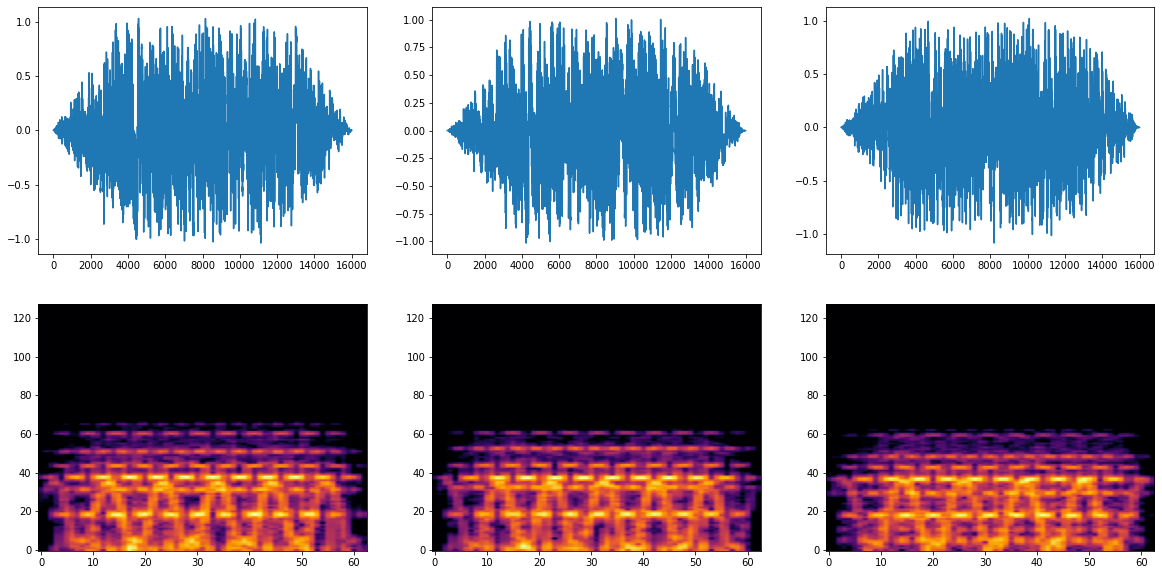

Sound 8 target

Sound 8 model1 prediction

Sound 8 model2 prediction

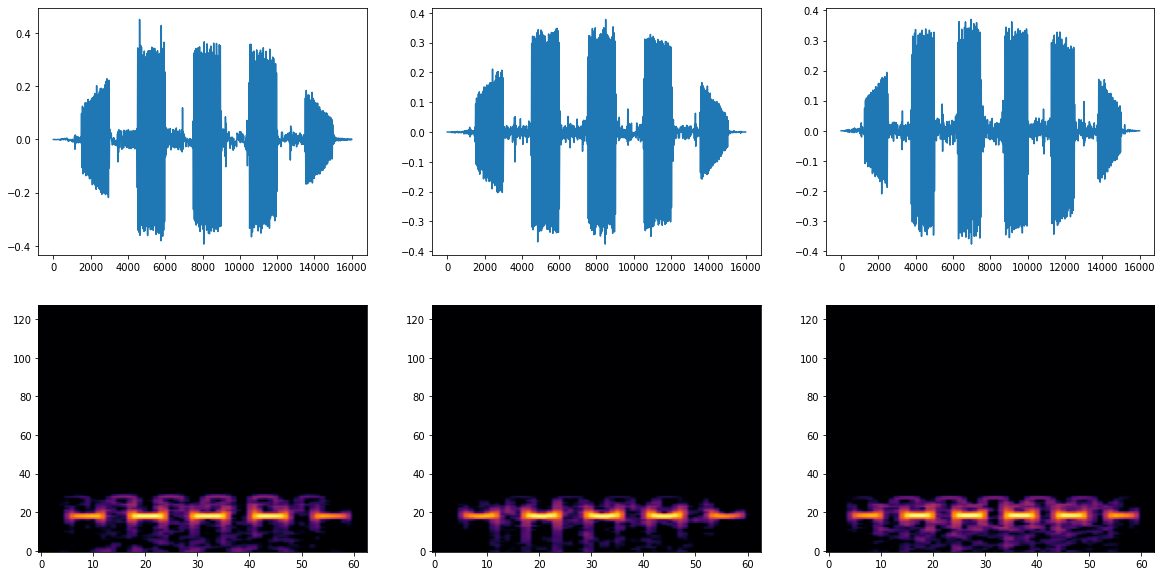

Sound 9 target

Sound 9 model1 prediction

Sound 9 model2 prediction

In [16]:
from IPython.display import display, Audio, Pretty


for i in range(batch_size):
    plot_result(results1['target_audio'][i], results1['predicted_audio'][i], results2['predicted_audio'][i],
                results1['target_spectrograms'][i], results1['predicted_spectrograms'][i], results2['predicted_spectrograms'][i])

    display(Pretty(f'Sound {i} target'))
    display(Audio(results1['target_audio'][i], rate=cfg.sample_rate, autoplay=False))

    display(Pretty(f'Sound {i} model1 prediction'))
    display(Audio(results1['predicted_audio'][i], rate=cfg.sample_rate, autoplay=False))

    display(Pretty(f'Sound {i} model2 prediction'))
    display(Audio(results2['predicted_audio'][i], rate=cfg.sample_rate, autoplay=False))
